Hugging Face T5 tokenizer based Experiment
Raw Dataset



## Total Object Models: 9


## Training

1.	Camping
2.	Customer_Order
3.	Ecommerce
4.	Onlinestore
5.	Decider
6.  Library OM
7.  CSOS
8.  Flagship

## Testing

9.	Bank





--------------------------------

## Total Training Data: 13236 (100%)
--------------------------------

### Training set P :  9265 (70% of Training Data)

### Training set NP : 3971 (30% of Training Data)

-----------------------------
## Total Testing Data: 32 (100% of Total Data)
----------------------------

### Testing set P : 8 (25% of Testing Data)

### Testing set NP : 24 (75%% of Testing Data)

In [4]:
import pandas as pd
import random
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import AutoTokenizer
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [5]:
# Define the maximum lengths for input and target sequences
MAX_INPUT_LENGTH = 500
MAX_TARGET_LENGTH = 500
vocab_size = 8000

In [6]:
# Load the data from the Excel file
file_path = "raw_8_om_training_set.xlsx"
data = pd.read_excel(file_path)

# Extract the source and target sequences
source_sequences = data["OM_Regular"].tolist()
target_sequences = data["OM_Prediction"].tolist()

In [7]:
# Initialize the T5 tokenizer with customized vocab size
tokenizer = AutoTokenizer.from_pretrained("t5-small", vocab_size=8000)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [8]:
# Tokenize the sequences
tokenized_sequences = []
for source, target in zip(source_sequences, target_sequences):
    tokenized_input = tokenizer(source, max_length=MAX_INPUT_LENGTH, truncation=True, padding="max_length", return_tensors="tf")
    tokenized_target = tokenizer(target, max_length=MAX_TARGET_LENGTH, truncation=True, padding="max_length", return_tensors="tf")

    tokenized_sequence_pair = {
        "input_ids": tokenized_input.input_ids[0],
        "attention_mask": tokenized_input.attention_mask[0],
        "decoder_input_ids": tokenized_target.input_ids[0],
        "decoder_attention_mask": tokenized_target.attention_mask[0]
    }

    tokenized_sequences.append(tokenized_sequence_pair)

In [9]:
# Shuffle the tokenized sequences
random.shuffle(tokenized_sequences)


In [10]:
# Split the dataset into train, validation, and test sets
num_val_samples = int(0.15 * len(tokenized_sequences))
num_train_samples = len(tokenized_sequences) - 2 * num_val_samples
train_pairs = tokenized_sequences[:num_train_samples]
val_pairs = tokenized_sequences[num_train_samples : num_train_samples + num_val_samples]
test_pairs = tokenized_sequences[num_train_samples + num_val_samples :]

print(f"Total pairs: {len(tokenized_sequences)}")
print(f"Training pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"Test pairs: {len(test_pairs)}")


Total pairs: 13336
Training pairs: 9336
Validation pairs: 2000
Test pairs: 2000


In [11]:
# Define constants and hyperparameters
sequence_length = MAX_INPUT_LENGTH  # Assuming input and target sequences have the same length
batch_size = 64

In [12]:
# Define the format_dataset function
# Adjusted format_dataset function to include target data
def format_dataset(pair):
    return (
        {
            "encoder_inputs": pair["input_ids"],
            "decoder_inputs": pair["decoder_input_ids"],
        },
        pair["decoder_input_ids"]  # Target data
    )

# Adjusted make_dataset function to return both input and target tensors
def make_dataset(pairs):
    def generator():
        for pair in pairs:
            yield format_dataset(pair)

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        {
            "encoder_inputs": tf.TensorSpec(shape=(sequence_length,), dtype=tf.int32),
            "decoder_inputs": tf.TensorSpec(shape=(sequence_length,), dtype=tf.int32)
        },
        tf.TensorSpec(shape=(sequence_length,), dtype=tf.int32)  # Target data
    ))

    return dataset.shuffle(2048).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Create the datasets
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


In [13]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


In [14]:
# Define the complete Transformer model
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(sequence_length,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(sequence_length,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(sequence_length, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

# Compile the model
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [15]:
epochs = 10
  # This should be at least 30 for convergence
# steps_per_epoch = 100,
transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)



Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 positional_embedding (Posi  (None, 500, 256)             2176000   ['encoder_inputs[0][0]']      
 tionalEmbedding)                                                                                 
                                                                                                  
 decoder_inputs (InputLayer  [(None, 500)]                0         []                            
 )                                                                                      

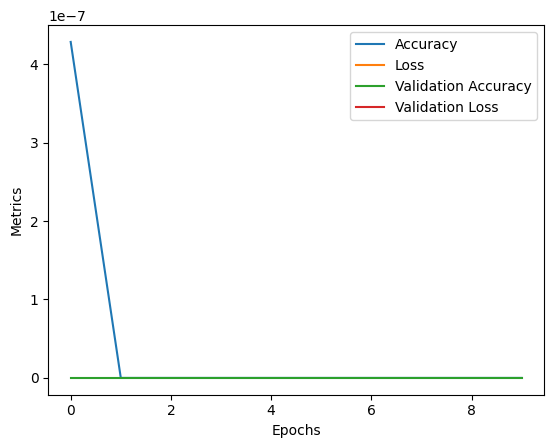

In [16]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


In [17]:
# Define the vocabulary and index lookup for the target language (Spanish)
spa_vocab = tokenizer.get_vocab()
spa_index_lookup = {idx: token for token, idx in spa_vocab.items()}
max_decoded_sentence_length = 500

def decode_sequence(input_sentence):
    tokenized_input_sentence = tokenizer.encode(input_sentence, return_tensors="tf", max_length=MAX_INPUT_LENGTH, truncation=True, padding="max_length")
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = tokenizer.encode(decoded_sentence, return_tensors="tf", max_length=MAX_TARGET_LENGTH, truncation=True, padding="max_length")
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence

# Example usage
test_eng_texts = [pair["input_ids"] for pair in test_pairs]
for input_sentence in test_eng_texts:
    input_sentence = tokenizer.decode(input_sentence)
    translated = decode_sequence(input_sentence)
    print(f"Input: {input_sentence}")
    print(f"Translated: {translated}\n")

Input: module ecommerceopen Declarationone sig Customer extends Class<unk>attrSet = customerIDid=customerIDisAbstract = Nono parent<unk>one sig customerID extends Integer<unk>one sig Order extends Class<unk>attrSet = orderIDid=orderIDisAbstract = Nono parent<unk>one sig orderID extends Integer<unk>one sig CustomerOrderAssociation extends Association<unk>src = Customerdst = Ordersrc_multiplicity = ONEdst_multiplicity = MANY<unk>one sig ShippingCart extends Class<unk>attrSet = shippingCartIDid=shippingCartIDisAbstract = Nono parent<unk>one sig shippingCartID extends Integer<unk>one sig CustomerShippingCartAssociation extends Association<unk>src = Customerdst = ShippingCartsrc_multiplicity = ONEdst_multiplicity = MANY<unk>one sig Item extends Class<unk>attrSet = ItemID+quantityid=ItemIDisAbstract = Nono parent<unk>one sig ItemID extends Integer<unk>one sig quantity extends Integer<unk>one sig CartItem extends Class<unk>attrSet = cartItemIDone parentid=ItemIDisAbstract = Noparent in Item<u

KeyboardInterrupt: 

## Adding Data From Test Set

In [18]:
import pandas as pd


dc = pd.read_excel('Bank_authentic_testset.xlsx')

In [19]:
dc.head()

,OM_Regular,OM_Prediction
0,"module OM_name: 0, open Declaration one sig cl...",1
1,"module OM_name: 0, open Declaration one sig cl...",1
2,"module OM_name: 0, open Declaration one sig cl...",1
3,"module OM_name: 0, open Declaration one sig cl...",1
4,"module OM_name: 0, open Declaration one sig cl...",0


In [20]:
X_test2 = dc['OM_Regular'].values
y_test2 = dc['OM_Prediction'].values

In [21]:
print(X_test2.shape)
print(y_test2.shape)

print("X data type: ", X_test2.dtype)
print("y data type: ", y_test2.dtype)

(32,)
(32,)
X data type:  object
y data type:  int64


In [22]:
print(y_test2)

[1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0]


## Output From Unseen Data

In [23]:
inputs = X_test2

In [24]:
import time
import pandas as pd

def save_responses_to_excel(filename, responses):
    df = pd.DataFrame({'OM_Regular': inputs, 'OM_Prediction': responses})
    # Apply the conditions to set values in OM_Prediction column
    df['OM_Prediction'] = df['OM_Regular'].apply(lambda x: 1 if x.startswith('[start] p') else 0)
    df.to_excel(filename, index=False)

start_time = time.time()
mylist_res = []
for sentence in inputs:
    result = decode_sequence(sentence)
    mylist_res.append(result)
    print(result)
    time.sleep(1)  # Add a 1-second delay between each print statement

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time} seconds")
print(mylist_res)

# Save responses to the Excel file with OM_Prediction column values
save_responses_to_excel('Bank_authentic_testset_pred.xlsx', mylist_res)

[start] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p